# Deep Learning

## Assignment 7 google street view house number single digit

The goal is to make a cnn network to recognize google street view hourse number single digit, see [google_svhn](http://ufldl.stanford.edu/housenumbers/) format 2.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt

In [2]:
import random

def plot_sample_dataset(dataset, prediction_label, title = None):
    if title:
        plt.suptitle(title, fontsize = 11)
        
    sample_items = random.sample(range(dataset.shape[0]), 25)
    for index,item in enumerate(sample_items):
        plt.subplot(5,5,index + 1)
        plt.subplots_adjust(wspace = 0.2, hspace = 0.6)

        plt.title(prediction_label[item])
        plt.axis('off')
        plt.imshow(dataset[item])
    plt.show()

Training set (40000, 32, 32) (40000,)
Validation set (6000, 32, 32) (6000,)
Test set (10000, 32, 32) (10000,)


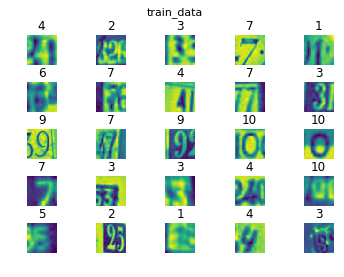

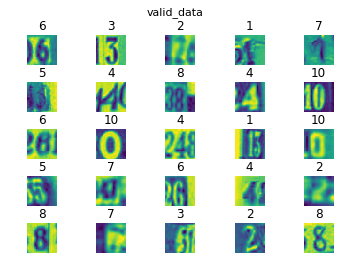

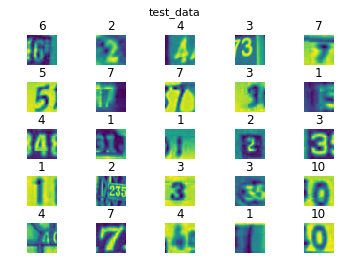

In [3]:
pickle_file = 'google_svhn_format2.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

  plot_sample_dataset(train_dataset, train_labels, 'train_data')
  plot_sample_dataset(valid_dataset, valid_labels, 'valid_data')
  plot_sample_dataset(test_dataset, test_labels, 'test_data')

  

Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings. (1-10, number '0' refered as 10)

In [4]:
image_size = 32
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(1,num_labels + 1) == labels[:,None]).astype(np.float32)
    # None refers to new axis
  labels = np.squeeze(labels)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (40000, 32, 32, 1) (40000, 10)
Validation set (6000, 32, 32, 1) (6000, 10)
Test set (10000, 32, 32, 1) (10000, 10)


Check if the 1-hot encodings are correct:

[ 8  3  1  5  1  6  8  1  5 10]


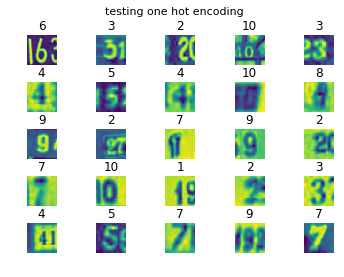

[4 1 3 2 2 1 5 8 4 3]


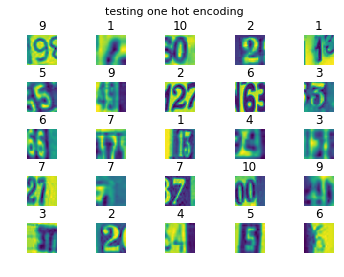

In [5]:
test_dataset_temp = np.squeeze(test_dataset)
test_labels_temp = np.argmax(test_labels, axis = 1) + 1
print(test_labels_temp[:10])

plot_sample_dataset(test_dataset_temp, test_labels_temp, 'testing one hot encoding')

valid_dataset_temp = np.squeeze(valid_dataset)
valid_labels_temp = np.argmax(valid_labels, axis = 1) + 1
print(valid_labels_temp[:10])

plot_sample_dataset(valid_dataset_temp, valid_labels_temp, 'testing one hot encoding')

In [6]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [7]:
print(accuracy(valid_labels, valid_labels))

100.0


Let's build a small network with 2*(convolution layer + relu + max pooling), followed by 2 fully connected layers, with L2 regulation

In [37]:
batch_size = 32
patch_size = 5
depth_1 = 16
depth_2 = 32
num_hidden_1 = 512
num_hidden_2 = 1024
num_hidden_3 = 1024
initial_learning_rate = 0.01
decay_steps = 1000
decay_rate = 0.95
image_size = 32
num_channels = 1
num_labels = 10
keep_prop = 0.5

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  tf_beta_regul = tf.placeholder(tf.float32)

  global_step = tf.Variable(0)  # count the number of steps taken.
  
  # Variables.
  # CNN variables
  layer1_w = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth_1], stddev = 0.3*np.sqrt(
            2.0/(patch_size*patch_size*num_channels))))
  layer1_b = tf.Variable(tf.zeros([depth_1]))
    
  layer2_w = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth_1, depth_2], stddev = 0.3*np.sqrt(
            2.0/(patch_size*patch_size*depth_1))))
  layer2_b = tf.Variable(tf.zeros([depth_2]))
    
  # Fully connected layers variables  
  layer3_w = tf.Variable(tf.truncated_normal(
      [(image_size // 4) * (image_size // 4) * depth_2, num_hidden_1], 
      stddev = 0.3*np.sqrt(2.0/((image_size // 4) * (image_size // 4) * depth_2))))
  layer3_b = tf.Variable(tf.zeros([num_hidden_1]))
    
  layer4_w = tf.Variable(tf.truncated_normal(
      [num_hidden_1, num_hidden_2], stddev = 0.3*np.sqrt(2.0/num_hidden_1)))
  layer4_b = tf.Variable(tf.zeros([num_hidden_2]))  
    
  layer5_w = tf.Variable(tf.truncated_normal(
      [num_hidden_2, num_hidden_3], stddev = 0.3*np.sqrt(2.0/num_hidden_2)))
  layer5_b = tf.Variable(tf.zeros([num_hidden_3]))  
    
  layer6_w = tf.Variable(tf.truncated_normal(
      [num_hidden_3, num_labels], stddev = 0.3*np.sqrt(2.0/num_hidden_3)))
  layer6_b = tf.Variable(tf.zeros([num_labels]))
    
  # Model.
  def model(data):
    # convolution 1
    conv = tf.nn.conv2d(data, layer1_w, [1, 1, 1, 1], padding='SAME')   
    # relu
    hidden = tf.nn.relu(conv + layer1_b)
    
    # max pooling
    max_pool = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='SAME')
    #hidden = tf.nn.dropout(max_pool, keep_prob = keep_prop)
    hidden = max_pool
    
    # convolution 2
    conv = tf.nn.conv2d(hidden, layer2_w, [1, 1, 1, 1], padding='SAME')    
    #relu
    hidden = tf.nn.relu(conv + layer2_b)
    
    # max pooling
    max_pool = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='SAME')
    #hidden = tf.nn.dropout(max_pool, keep_prob = keep_prop)
    hidden = max_pool
    
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    
    # fully connected 1
    y1 = tf.nn.relu(tf.matmul(reshape, layer3_w) + layer3_b)
    #y1 = tf.nn.dropout(y1, 0.5) 
    
    # fully connected 2
    y2 = tf.nn.relu(tf.matmul(y1, layer4_w) + layer4_b)
    #y2 = tf.nn.dropout(y2, 0.5) 
    
    # fully connected 3
    y3 = tf.nn.relu(tf.matmul(y2, layer5_w) + layer5_b)
    
    return tf.matmul(y2, layer6_w) + layer6_b
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
    ) + tf_beta_regul * (tf.nn.l2_loss(layer3_w) + tf.nn.l2_loss(layer4_w
    ) + tf.nn.l2_loss(layer5_w))
    
  # Learning rate
  learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step = global_step,
                                             decay_steps = decay_steps, decay_rate = decay_rate)
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(
      learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [41]:
num_steps = 100001
num_step = []
validation_accuracy = []
total_loss = []
beta_regul = 0.00032
#beta_val = np.logspace(-4,-2,5)
#test_accuracy_val = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, 
                    tf_beta_regul: beta}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
          num_step.append(step)
          validation_accuracy.append(accuracy(
            valid_prediction.eval(), valid_labels))
          total_loss.append(l)

          print('Minibatch loss at step %d: %f' % (step, l))
          print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
          print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), valid_labels))
        if (step % 10000 == 0):
            print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
            # this is an aggressive way of getting prediction results
            test_result = np.argmax(test_prediction.eval(), axis = 1) + 1


        

Initialized
Minibatch loss at step 0: 4.086605
Minibatch accuracy: 6.2%
Validation accuracy: 9.4%
Test accuracy: 10.2%
Minibatch loss at step 500: 3.917666
Minibatch accuracy: 18.8%
Validation accuracy: 10.9%
Minibatch loss at step 1000: 3.770246
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 1500: 3.638919
Minibatch accuracy: 9.4%
Validation accuracy: 10.0%
Minibatch loss at step 2000: 3.523844
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 2500: 3.418826
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 3000: 3.326973
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 3500: 3.243360
Minibatch accuracy: 6.2%
Validation accuracy: 10.2%
Minibatch loss at step 4000: 3.169150
Minibatch accuracy: 9.4%
Validation accuracy: 10.0%
Minibatch loss at step 4500: 3.100597
Minibatch accuracy: 21.9%
Validation accuracy: 10.0%
Minibatch loss at step 5000: 3.040948
Minibatch accuracy: 9.4%
Validat

KeyboardInterrupt: 

[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000, 20500, 21000, 21500, 22000, 22500, 23000, 23500, 24000, 24500, 25000, 25500, 26000, 26500, 27000, 27500, 28000, 28500, 29000, 29500, 30000, 30500, 31000, 31500, 32000, 32500, 33000, 33500, 34000, 34500, 35000, 35500, 36000, 36500, 37000, 37500, 38000, 38500, 39000, 39500, 40000, 40500, 41000, 41500, 42000, 42500, 43000, 43500, 44000, 44500, 45000, 45500, 46000, 46500, 47000, 47500, 48000, 48500, 49000, 49500, 50000, 50500, 51000, 51500, 52000, 52500, 53000, 53500, 54000, 54500, 55000, 55500, 56000, 56500, 57000, 57500, 58000, 58500, 59000, 59500, 60000, 60500, 61000, 61500, 62000, 62500, 63000, 63500, 64000, 64500, 65000, 65500, 66000, 66500, 67000, 67500, 68000, 68500, 69000, 69500, 70000, 0, 500, 1000, 1500, 2000, 2500, 3000

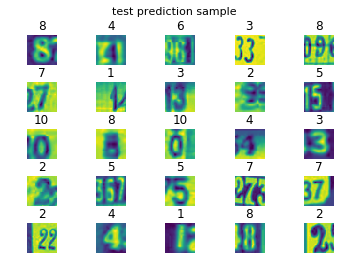

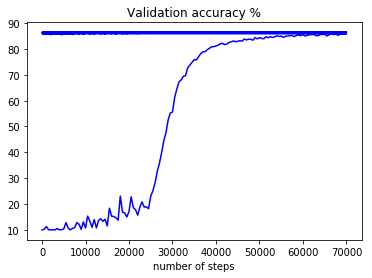

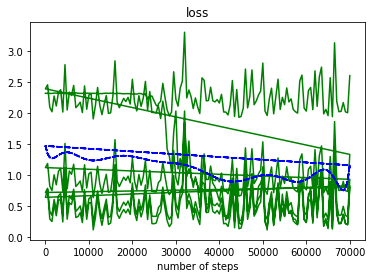

Best accuracy is 85.5% when beta is 0.00032


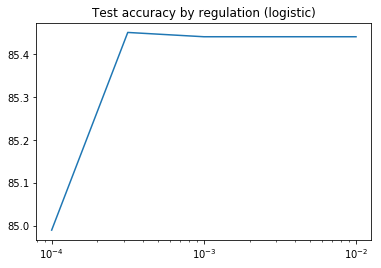

In [35]:
# plot test prediction sample
test_dataset_temp = np.squeeze(test_dataset)
plot_sample_dataset(test_dataset_temp, test_result, 'test prediction sample')

# plot validation accuracy
plt.plot(num_step, validation_accuracy, 'b-')
plt.title('Validation accuracy %')
plt.xlabel('number of steps')
plt.show()

# plot loss
poly_para = np.polyfit(num_step, total_loss, deg=12)
loss_polyfit = np.polyval(poly_para, num_step)

plt.plot(num_step, total_loss, 'g-')
plt.plot(num_step, loss_polyfit, 'b--')
plt.title('loss')
plt.xlabel('number of steps')
plt.show()



In [36]:
print(beta_val,test_accuracy_val)

[ 0.0001      0.00031623  0.001       0.00316228  0.01      ] [84.989999999999995, 85.450000000000003, 85.439999999999998, 85.439999999999998, 85.439999999999998]
